# Estatística & Probabilidade - 2022/02

## Projeto 02 - Uma introdução ao aprendizado de máquina

#### Aluna: Vitória Mendes Cortes Chaves

#### DRE: 120045487

# O projeto

O objetivo do projeto é trabalhar com a base de dados MNIST ("*Modified National Institute of Standards and Technology*"). Tal base consiste de 70.000 imagens de tamanho 28 x 28, em tons de cinza, contendo dígitos manuscritos, e o principal objetivo com ela é identificar qual é o dígito em questão. Algoritmos extremamente sofisticados (e pesadíssimos!) chegam a atingir uma taxa de erro de 0,17%, mas aqui vamos trabalhar com um algoritmo bem mais simples, o classificador de Bayes ingênuo Gaussiano, introduzido acima. Para tal, vamos usar o pacote `scikit-learn` (https://scikit-learn.org/stable/), que implementa diversos algoritmos de aprendizado de máquina de forma muito eficiente e de fácil uso. Abaixo seguem alguns códigos para melhor guiá-los, e no meio há instruções para o que deve ser feito no projeto.

In [1]:
#@title
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print("Imports concluídos")

Imports concluídos


## A base de dados

Primeiramente, vamos carregar e fazer uma análise preliminar na base de dados.

In [2]:
#@title
# Baixando a base de dados

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=True)

In [3]:
#@title
# Vendo o cabeçalho referente à X, bem como seu tamanho

print(X.shape)
X.head()

(70000, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#@title
# Vendo o cabeçalho referente à y, bem como seu tamanho

print(y.shape)
y.head()

(70000,)


0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Como podemos ver acima, `X` é um *dataframe* de 70.000 linhas e 784 colunas, e `y` é um *array* de tamanho 70.000, contendo o número referente a cada linha de `X`. Portanto, cada linha de `X` representa uma imagem de um dígito manuscrito. Vejamos alguns exemplos:

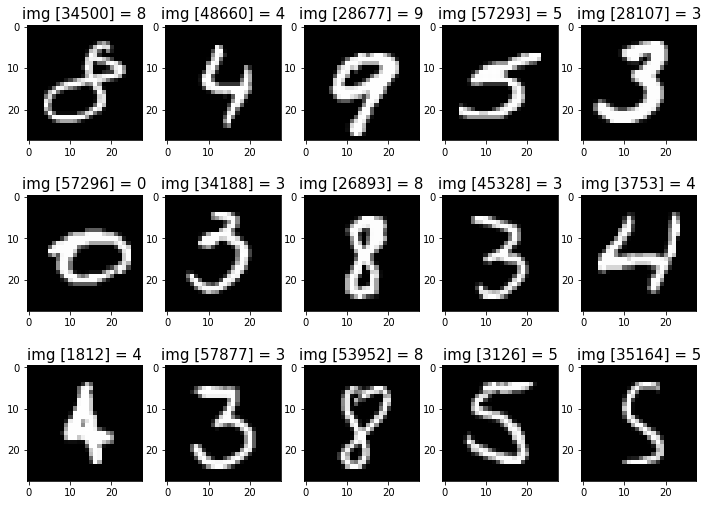

In [5]:
#@title
# FONTE: https://www.kaggle.com/code/soham1024/basic-neural-network-from-scratch-in-python

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(12, 12))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0].reshape(28, 28)        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# codigo extraído em método para aproveitar as imagens tanto na impressão original quanto nas comparações feitas com previsões da IA
# formatei a visualização a fim de mostrar os resultados de comparação como vistos na imagem da questão 7.
def expectVsReality(lista_img=[], previsao=[], lista_real=[]):
  random_images = []
  if (len(previsao) == 0):
    
    for i in range(0, 15):
        r = np.random.randint(1, 70000)
        random_images.append((X.values[r], 'img [' + str(r) + '] = ' + str(y[r])))

    show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))
  else:
    r = np.random.randint(15,10000)
    for i in range(r-15, r):
        random_images.append((lista_img.values[i], 'img [' + str(lista_img.index[i]) + ']' + '\n' + ' Pred: '+ str(previsao[i]) + ' Real: ' + str(lista_real.values[i])))
    show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

expectVsReality()

Acima, nós vimos como são algumas das linhas de `X` pensadas como uma imagem de tamanho 28 x 28. Agora, vamos estudar a sua estrutura como um vetor de tamanho 784.

Dígito: 7


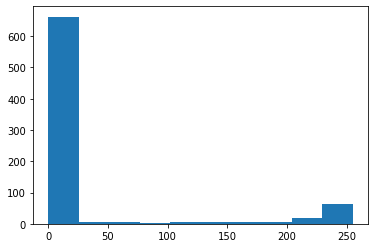

In [6]:
#@title
r = np.random.randint(1, 70000)
plt.hist(X.values[r])
print('Dígito:', y[r])
plt.show()

Portanto, do ponto de vista estatístico, cada linha do *dataframe* `X` consiste de 784 observações de variáveis aleatórias que tomam seus valores entre 0 e 255 e concentram-se principalmente em torno de tais valores. Essa é exatamente a estrutura de uma imagem em tons de cinza: o valor igual a 0 representa um *pixel* totalmente preto e um valor igual a 255 representa um *pixel* totalmente branco. Recomendo rodar diversas vezes o bloco acima, para verificar como varia o histograma dos tons de cinza. Nosso objetivo será tentar identificar qual dígito está sendo representado por determinado vetor de tamanho 784 (cujas componentes chamaremos de *atributos*), utilizando o classificador de Bayes ingênuo gaussiano que discutimos acima.

**QUESTÃO 1:** O classificador de Bayes ingênuo Gaussiano tem duas hipóteses: condicionado na classe, os atributos são (1) independentes e (2) descritos por distribuições normais (com parâmetros desconhecidos). "Traduza" o que isso significa na linguagem do problema em questão (quais são nossos atributos? nossas classes? etc...), e discorra sobre a razoabilidade de tais hipóteses em nosso cenário.

*BÔNUS*: Apresente uma análise exploratória para justificar as suas conclusões.

-----------------------------------------------------------------------------------------

``Solução:``
Dentro do nosso cenário proposto, temos que os atributos são pixels da imagem montados por 28x28, e as classes são dígitos de 0 a 9.
O classificador de Bayes Ingênuo Gaussiano traduzido para o problema nos diz que  para cada classe, os pixels das imagens são independentes uns dos outros e podem ser descritos por distribuições normais.


``Independência:``
Apesar de considerarmos independência, intuitivamente concluímos que não ocorre, pois é provável que ocorra dependência entre os pixels ja que eles podem possuir cores muito semelhantes entre si, visto que como nosso cenário se trata de manuscritos de números, podemos ter traços mais leves, mais fortes, o que acarretam em tons variados para um mesmo dígito.
Vamos observar na célula abaixo com o exemplo do dígito 3 manuscrito:





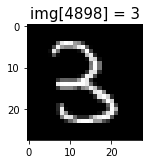

In [7]:
#@title
#imprimindo a imagem do 3:
images = []
images.append((X.values[4898], 'img[' + str(X.index[4898]) + '] = ' + str(y.values[4898])))
show_images(list(map(lambda x: x[0], images)), list(map(lambda x: x[1], images)))

Agora, vamos dar um zoom nela e visualizar seus pixels, note na similaridade da escala de cinza com o branco quando observamos a imagem completa na célula acima (a execução demora aprox 36s):

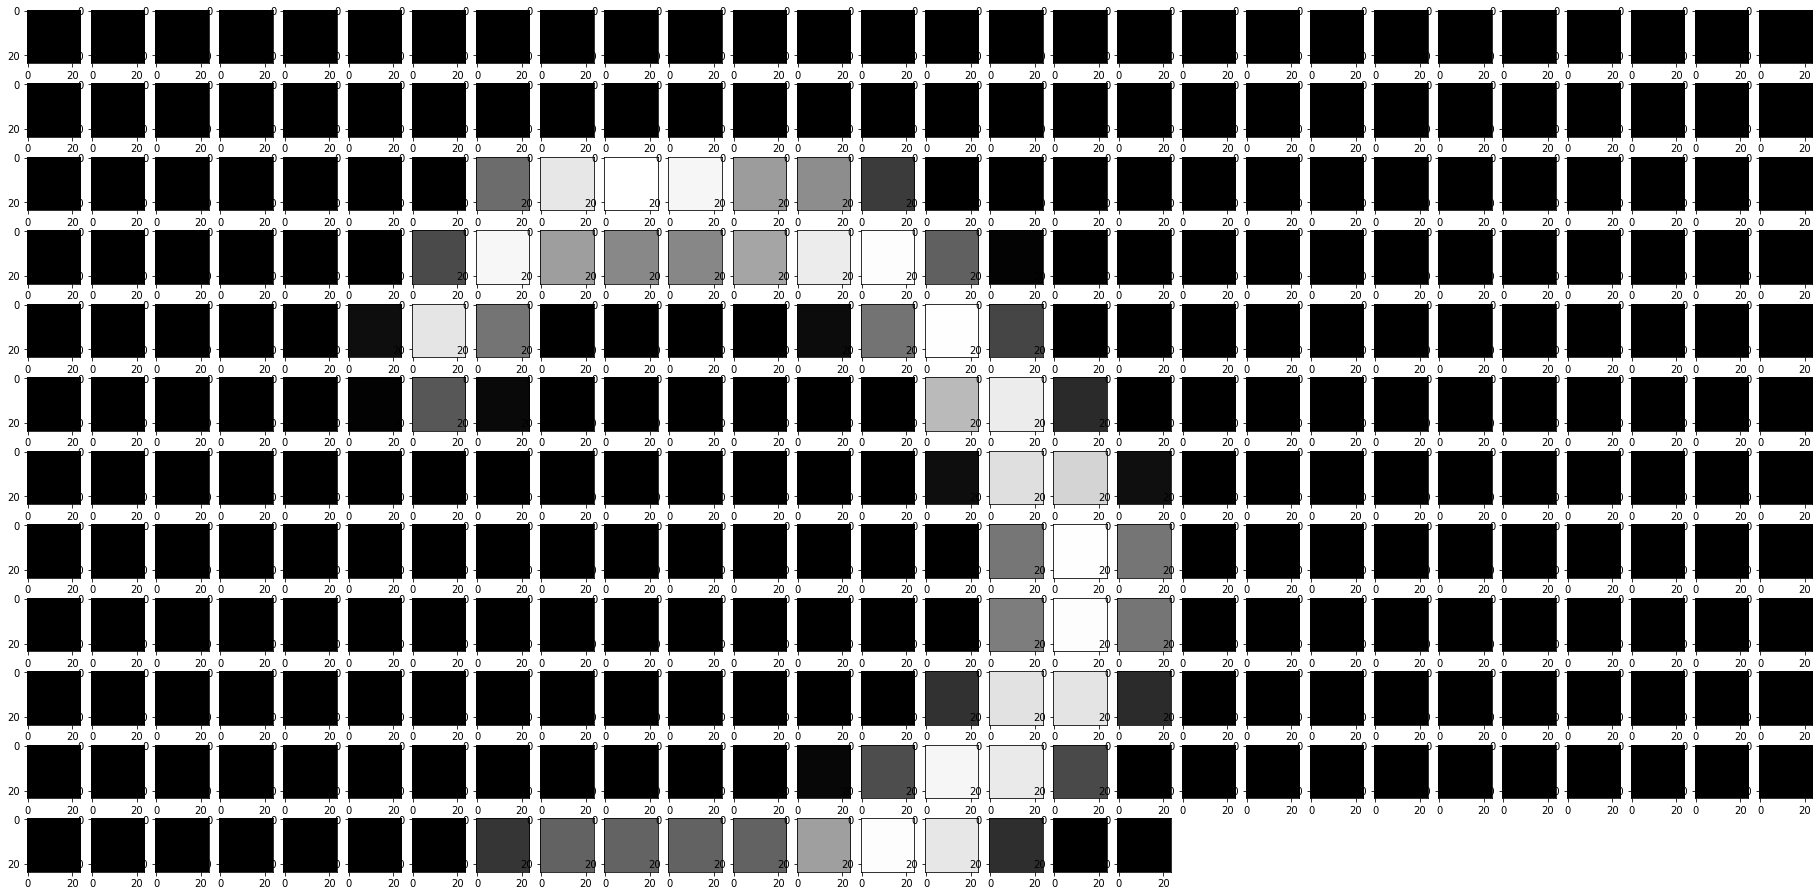

In [8]:
#@title
#Gerando imagens dos pixels para visualização de não independência
#Primeiro criei a lista de cores, que será populada com imagens de cada pixel
cores = []
legendas = []
for i in range(0,256):
  image = Image.new('RGB', (24, 24), color=(i, i, i))
  image.save('image.png')
  image = Image.open('image.png')
  image = np.array(image)
  cores.append(image)
  

#Reescrevendo e adaptando a função referenciada na célula inicial para mostrar as imagens dos pixels
def mostrar_imagens(images, title_texts):
  cols = 28
  rows = int(len(images)/cols) + 1
  plt.figure(figsize=(32, 16))
  index = 1    
  for x in zip(images, title_texts):      
      image = x[0]
      title_text = x[1]
      plt.subplot(rows, cols, index)        
      plt.imshow(image, cmap=plt.cm.gray)
      if (title_text != ''):
          plt.title(title_text, fontsize = 10);        
      index += 1

# Capturando uma imagem aleatória de um manuscrito referente ao dígito 3 para análise de "zoom" dos pixels da imagem original
pixels = X.values[4898]
coresDigito = []
for i in range(56, 382):
  cor = cores[int(pixels[i])]
  coresDigito.append(cor)
  legendas.append('')

mostrar_imagens(coresDigito,legendas)

``Distribuição Normal (Gaussiana):``
Por considerarmos que podemos modelar por distribuição normal temos que ela pode calculada em função de dois parâmetros: a média e uma variável aleatória (variância), que é responsável por aferir a dispersão dos dados, logo, como observamos no gráfico abaixo, em relação a um dígito, podemos notar que ocorre uma grande concentração de pixels nos dois extremos 0 e 255, (preto e branco).



Pixel 300 em relação ao rótulo 8 (0: preto, 1: branco)


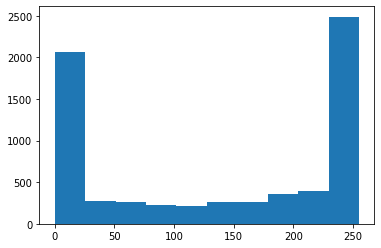

In [9]:
#@title
plt.hist(X['pixel300'].values[y == '8'])
print("Pixel 300 em relação ao rótulo 8 (0: preto, 1: branco)")
plt.show()

É demonstrado então, que a hipótese de distribuição normal não se mantém para todos os dígitos, porém em alguns pixels podem haver distribuições similares a normal, como ilustrado abaixo:

Pixel 30 em relação ao rótulo 8 (0: preto, 1: branco)


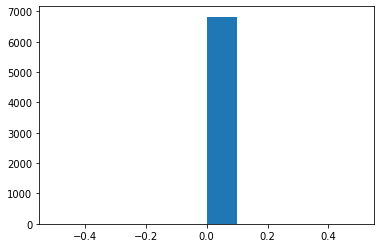

In [10]:
#@title
plt.hist(X['pixel30'].values[y == '8'])
print("Pixel 30 em relação ao rótulo 8 (0: preto, 1: branco)")
plt.show()


 Ademais, o fato de não haver total semelhança sobre a descrição dos pixels em independência e variáveis aleatórias normais não descreverem totalmente o problema, não ocorrem graves problemas na utilização desse classificador pois ainda conseguimos resultados razoáveis por meio da sua implementação em aprendizagem de máquina.

-----------------------------------------------------------------------------------------

Para melhorar a magnitude de nossos dados, iremos fazer uma espécie de normalização, dividindo todos os valores de `X` por 255, para que tenhamos sempre valores entre 0 e 1.

In [11]:
#@title
# ATENÇÃO! Se você rodar essa célula mais de uma vez, vai estar "comprimindo" ainda mais os valores de X! Recomendo não fazer isso para evitar erros numéricos.

X = X/255

## Classificando a base

Uma prática em aprendizagem de máquina é dividir nossa base de dados em duas partes: um *conjunto de treinamento* e um *conjunto de teste*. O primeiro será usado para estimarmos os parâmetros que o classificador precisará, e o segundo será usado para medir a sua performance. O `scikit-learn` tem ferramentas que fazem essa separação de modo automático. Abaixo, deixamos 60.000 observações para treinamento e 10.000 para teste. Para garantir igual representatividade das classes em ambos os conjuntos fazemos uma *amostragem estratificada*, através do parâmetro `stratify = y`.

In [12]:
#@title
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, shuffle = True, stratify = y)

**QUESTÃO 2:** A classe que vamos usar para fazer o nosso procedimento é a `GaussianNB`, localizada dentro do módulo `naive_bayes`. A documentação do `scikit-learn` é bastante informativa, e particularmente me ajuda bastante a entender os algoritmos lá implementados. Portanto, leiam a documentação referente ao `GaussianNB` (https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), e a página direcionada através do *link* "User Guide", onde encontra-se a formulação matemática por trás do método em questão. Após essa leitura, façam uma comparação do que lá é dito com o que foi apresentado acima sobre o método de classificação proposto, elencando pontos onde há semelhanças e divergências. Em particular, descreva o que os métodos `fit`, `predict` e `predict_proba` fazem.

-----------------------------------------------------------------------------------------

``Solução``

``Comparação:``A descrição referente ao classificador de Bayes Ingênuo dada neste projeto e na documentação do scikit learn são equivalentes, ambas nos dizem que é um classificador de Bayes ingenuo cujos atributos são ditos independentes e seguem uma distribuição normal, no caso do nosso problema, os pixels relacionados aos manuscritos dos dígitos.



``fit:``é usado para treinar o classificador a partir dos dados de treinamento. Ele calcula os parâmetros das distribuições Gaussianas para cada classe a partir dos dados e os armazena internamente para uso posterior, ele basicamente calcula a média e a variância das distribuições Gaussianas para cada classe.


$$\mu_{dj} = \frac{1}{n_{d}} \sum_{i = 1}^{n} X_{ij} ~~~~~ \sigma_{dj}^2 = \frac{1}{n_{d}} \sum_{i = 1}^{n} (X_{ij} - \mu_{dj})^2$$ 
onde $\mu_{dj}$ é a média, e $\sigma_{dj}^2$ é a variância, $n_d$ é o número de amostras na classe $d$, e $X_{ij}$ é o valor da j-ésima característica da i-ésima amostra.


``predict:`` é usado para fazer previsões de classe para novos exemplos. Ele usa os parâmetros das distribuições Gaussianas armazenadas internamente para calcular a probabilidade de cada classe para cada novo exemplo e escolhe a classe com a maior probabilidade como a previsão.

Calcula as probabilidades seguindo a seguinte fórmula:
$$\mathbb{P}(Y = d | \mathbf{X} = \mathbf{x}) = \frac{q(\mathbf{X} = \mathbf{x} | Y = d)\mathbb{P}(Y = d)}{\sum_{c \in \mathcal{C}} q(\mathbf{X} = \mathbf{x} | Y = c)\mathbb{P}(Y = c)}$$


``predict_proba:``é usado para calcular a probabilidade de cada classe para cada novo exemplo. Ele usa os parâmetros das distribuições Gaussianas armazenadas internamente para calcular a probabilidade de cada classe para cada novo exemplo e retorna essas probabilidades em um array, utiliza a mesma fórmula que o método predict.



-----------------------------------------------------------------------------------------

**QUESTÃO 3:** Agora é a sua vez de trabalhar sobre a base de dados que apresentamos! Use o `GaussianNB` para treinar um modelo de Bayes ingênuo gaussiano nos conjuntos `X_train` e `y_train`, e prever os resultados no conjunto `X_test`. Agora, com um exemplo concreto em mãos, revisite o que os métodos  `predict` e `predict_proba` fazem. Uma dica é olhar os exemplos na documentação do `scikit-learn`.

-----------------------------------------------------------------------------------------

``Solução:``



Treinando o modelo Naive Bayes e ilustrando resultados:

Previsão realizada:


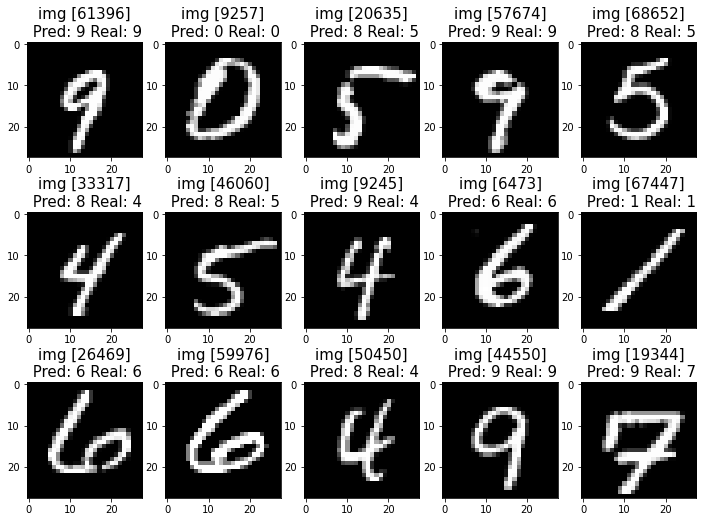

In [13]:
#@title
# Criando o modelo
model = GaussianNB()

# Treinando o modelo com os dados de treinamento
model.fit(X_train, y_train)

# O modelo treinado faz previsões no conjunto de teste:
pred_test = model.predict(X_test)

# O modelo treinado faz previsões de probabilidade no conjunto de teste:
pred_proba_test = model.predict_proba(X_test)

#método que extraí das células iniciais para visualizar meus resultados
print("Previsão realizada:")
expectVsReality(X_test, pred_test,y_test)

-----------------------------------------------------------------------------------------

**QUESTÃO 4:** Nós temos um conjunto de dados relativamente grande, com 60.000 observações. Para ajustar um classificador de Bayes ingênuo gaussiano, quantos parâmetros nós precisamos estimar? Compare esse número com o tamanho do conjunto de treinamento, e diga o que você pode esperar da qualidade de tais estimativas pontuais.

-----------------------------------------------------------------------------------------

``Solução:``


No classificador de Bayes ingênuo gaussiano, precisamos estimar um número de parâmetros igual a $2×|C|×𝑝$, onde $|C|$ é o número de classes possíveis, e 𝑝 é o número de atributos (pixels, no caso da base de dados MNIST). Isso significa que, para cada classe 𝑑 ∈ C, precisamos estimar os parâmetros $𝜇_{𝑑𝑗}$ e $𝜎^2_{𝑑𝑗}$, para $𝑗=1,…,𝑝$. No caso da base de dados MNIST, temos:  

        |C|=10 classes possíveis (dígitos de 0 a 9) 
         p = 28×28=784 pixels

Que resulta em um total de $2×10×784=15680$ parâmetros a serem estimados. 

As estimativas resultantes não são boas, pois podem afetar negativamente a qualidade das estimativas pontuais. Isso se deve ao fato de que há muito poucos dados disponíveis para estimar cada parâmetro, resultando em estimativas com baixa precisão. Na qual o modelo se ajusta muito bem aos dados de treinamento, mas possui um baixo desempenho em novos dados.




-----------------------------------------------------------------------------------------

**QUESTÃO 5:** Bom, agora nós temos um classificador e temos como prever o resultado da classificação no nosso conjunto de teste. Mas como podemos *medir* o desempenho de nosso classificador? Estude sobre a *matriz de confusão* e sobre a *acurácia* de um classificador, e disserte sobre essas duas quantidades. Relacione a quantidade retornada pelo método `score` com a acurácia que você acabou de estudar.

Recomendação:
* https://en.wikipedia.org/wiki/Confusion_matrix [A matriz de confusão aqui será referente a um problema de classificação *binário*, enquanto que estamos tratando de um problema de classificação *multiclasse*. Tome cuidado com essa diferença]
* https://en.wikipedia.org/wiki/Accuracy_and_precision

*BÔNUS:* Porque acima nós falamos somente sobre aferir a qualidade do classificador no conjunto de teste e não no de treinamento? Discuta sobre esse ponto.





-----------------------------------------------------------------------------------------

``Solução``


``Acurácia do classificador:`` É a porcentagem de previsões corretas do classificador em relação ao total de previsões. Ela pode ser calculada pela soma dos valores da diagonal principal da matriz de confusão e dividindo pelo total de amostras de teste.

O método score de um classificador, por sua vez, retorna a acurácia da previsão do classificador em um conjunto de dados de teste. Porém, pelo método score não temos tanta precisão e detalhes sobre os erros/acertos, pois só leva em consideração as diagonais, enquanto na acurácia descrita na wiki, leva em consideração a matriz de confusão completa.

Abaixo a acurácia retornada pelo método score:


In [14]:
#@title
acuracia = model.score(X_test, y_test)

print("Acurácia (score): " + "{0:.0%}".format(acuracia))

Acurácia (score): 56%



``Matriz de Confusão:``É uma tabela que mostra as freqüências com as quais os valores previstos pelo classificador correspondem aos valores observados na verdade. A diagonal principal da matriz de confusão consiste em valores para os quais o classificador previu corretamente a classe, enquanto os valores fora da diagonal principal são para as classes que o classificador previu incorretamente.

In [15]:
#@title
labels = y.cat.categories
cm = confusion_matrix(y_test, pred_test, labels=labels)
print("Matriz de confusão:")
print(cm)

Matriz de confusão:
[[ 877    2    4    3    2    2   26    0   55   15]
 [   2 1063    3    2    0    1   16    0   29    9]
 [  81   25  280   53    7    3  264    0  274   12]
 [  39   51    7  342    1    3   50    7  424   96]
 [  17   14    6    4  168    7   79    4  210  466]
 [  77   22    5   17    5   42   50    0  607   77]
 [   7   18    2    0    1    2  912    0   36    4]
 [   3    3    1    6    5    0    1  298   54  671]
 [  17  120    2    8    4    9    8    1  643  163]
 [   4    6    4    3    7    0    1   16   16  937]]


```Solução Bônus:```O objetivo de usar um conjunto de teste é avaliar o desempenho do classificador em dados que ele não viu durante o processo de treinamento. Se usássemos o conjunto de treinamento para avaliar o classificador, teríamos maior acurácia, pois o classificador já "conhece" os rótulos desses dados. Além disso, conseguimos ter uma ideia mais precisa de como ele irá se comportar em dados novos, o que é importante para sua aplicação em problemas reais, onde ele também deverá saber lidar com resultados inesperados.

-----------------------------------------------------------------------------------------

**QUESTÃO 6:** Use o código dado abaixo para exibir a matriz de confusão, bem como uma representação gráfica mais amigável dela. Analise os erros cometidos pelo classificador e tente justificá-los, com base nas hipóteses do classificador e da natureza da base de dados. Calcule também a acurácia do classificador estimado. À luz dessas duas informações, extraia alguma conclusão sobre o classificador ser "bom" ou "ruim", em seu ponto de vista. Note que sua ponderação deve levar em consideração também o custo computacional de nosso classificador! Use como um "pior classificador possível" aquele que atribui uma observação a qualquer um dos dígitos de 0 até 9, aleatoriamente.

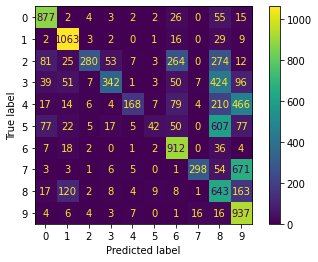

In [16]:
#@title
# A variável y_test_pred abaixo deverá ser a previsão do seu classificador no conjunto de teste, ou seja, em X_test.

# extraindo em método para diminuir linhas de código nas ilustrações posteriores
def matriz_confusao(y_test, pred_test):
  labels = y.cat.categories
  cm = confusion_matrix(y_test, pred_test, labels=labels)
  disp = ConfusionMatrixDisplay(cm, display_labels = labels)
  disp.plot()
  plt.show()

matriz_confusao(y_test, pred_test)

-----------------------------------------------------------------------------------------

``Solução:`` Analisando a matriz de confusão e a acurácia obtida pelo nosso classificador de Bayes ingênuo gaussiano, podemos notar maiores acertos nos dígitos 0,1,6 e 9 e o dígito que houve menos acertos foi o 5.
Podemos concluir que o classificador tem um desempenho razoável. Embora haja alguns erros, 4 das 10 previsões estão corretas, o que indica que o classificador é capaz de aprender as características dos dígitos e realizar previsões precisas. 

Avaliaria o classificador como bom, pois consegue chegar a 56% de acurácia como calculado acima e chegar em resultados eficazes em pouco tempo de execução, nos mostrando que é bastante otimizado, pois consiste em um classificador relativamente simples, que não requer muito poder de processamento para ser treinado e utilizado.



-----------------------------------------------------------------------------------------

**QUESTÃO 7:** Finalmente, após ter realizado todos esses experimentos, descreva quais hipóteses poderiam ser aprimoradas em nosso classificador, para que ele seja mais condizente com a base de dados e, portanto, possivelmente apresente um resultado melhor.

Note que não há como atingir 100% de acurácia neste problema. Veja abaixo algumas instâncias especialmente complicadas, e possivelmente rotuladas erroneamente:

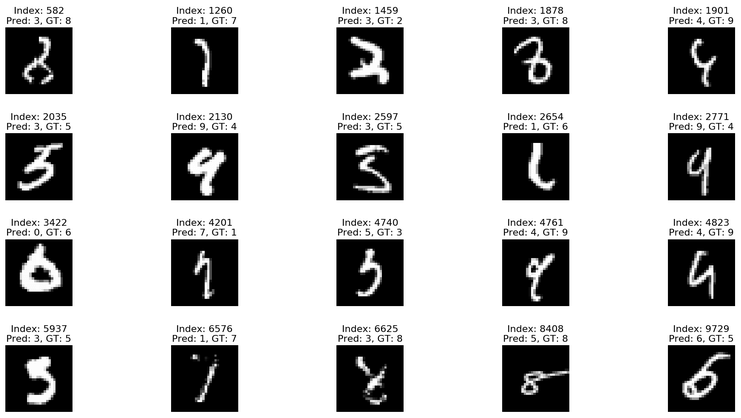

-----------------------------------------------------------------------------------------

``Solução:``
A hipótese de independência no nosso cenário poderia ser aprimorada utilizando o classificador Análise Discriminante Linear (também conhecido como LDA), que consiste em um método de classificação que tenta encontrar a melhor projeção linear dos dados em um número menor de dimensões, de modo que a separação entre as classes seja maximizada. 

Ele assume que cada classe tem uma distribuição Gaussiana e que as médias das distribuições das classes são diferentes. Isso pode ser expressado em termos de dependência de variáveis aleatórias (se encaixando no nosso cenário, em que a independência causa furos).

Basicamente é feito minimizando a variância dentro de cada classe enquanto maximiza a distância entre as médias das classes.



Vamos treinar nosso modelo seguindo a classificação LDA na célula abaixo:

In [18]:
#@title
# Criando o modelo LDA
dependente = LinearDiscriminantAnalysis()

# Treinando o modelo com os dados de treinamento
dependente.fit(X_train, y_train)

# O modelo treinado faz previsões no conjunto de teste:
pred_test_d = dependente.predict(X_test)

Agora, vamos calcular sua acurácia:

In [19]:
#@title
#Calculando a acurácia:
acuracia = dependente.score(X_test, y_test)
print("Acurácia do classificador LDA (score): " + "{0:.0%}".format(acuracia))

Acurácia do classificador LDA (score): 87%


Na célula abaixo podemos ver 15 resultados de previsões feitas pelo modelo e seus valores reais:

Previsão realizada:


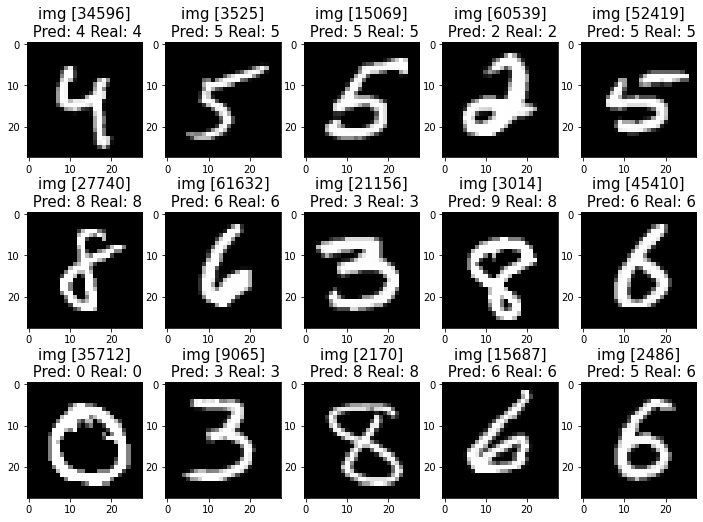

In [20]:
#@title
#método que extraí das células iniciais para visualizar meus resultados
print("Previsão realizada:")
expectVsReality(X_test, pred_test_d,y_test)

Podemos notar um aumento significativo na acurácia utilizando o classificador LDA, o que nos fornece resultados 30% mais precisos e com maior taxa de acertos dos dígitos. Como podemos observar nos resultados previstos e ilustrados acima com os manuscritos e a tabela de confusão ilustrada abaixo:

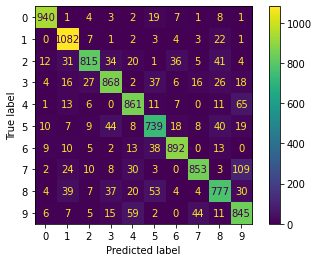

In [21]:
#@title
matriz_confusao(y_test, pred_test_d)

-----------------------------------------------------------------------------------------

Fonte extra utilizada:

  [Livro Data Science do Zero](https://www.amazon.com.br/Data-Science-zero-Joel-Grus/dp/857608998X): Possui uma introdução bem legal sobre Estatística, Visualização de Dados, Classificador Naive Bayes, etc


-----------------------------------------------------------------------------------------